In [1]:
%load_ext autoreload

In [178]:
%autoreload
import functools

import blackjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pears
from gaul import advi, hmc, quap
from gaul.utils import pbar
from jax.scipy import stats
from tqdm.auto import tqdm

<ErrorbarContainer object of 3 artists>

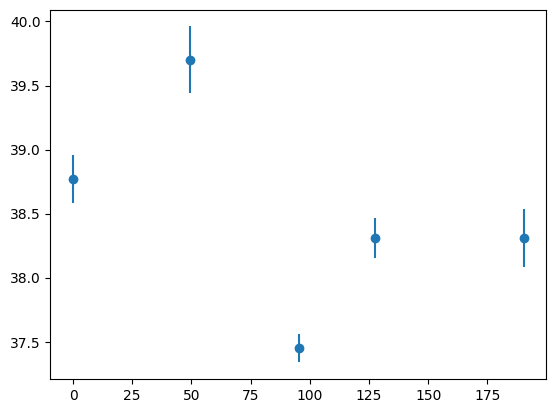

In [76]:
t = jnp.array([0.0, 49.452, 95.393, 127.587, 190.408])
rv = jnp.array([38.77, 39.70, 37.45, 38.31, 38.31])
err = jnp.array([0.184, 0.261, 0.112, 0.155, 0.223])
plt.errorbar(t, rv, yerr=err, ls="none", marker="o")

In [43]:
@jax.jit
def forward(params, data):
    omega = 2.0 * np.pi / params["P"]
    v = params["v0"] + params["K"] * jnp.cos(omega * data["t"] + params["phi"])
    return v

In [91]:
@jax.jit
def log_prob(params, data):
    l = 0.0

    v = forward(params, data)
    l += stats.norm.logpdf(data["v"], v, data["err"]).sum()

    l += stats.uniform.logpdf(
        jnp.log(params["P"]), jnp.log(data["Pmin"]), jnp.log(data["Pmax"])
    )
    l += stats.uniform.logpdf(params["phi"], 0.0, 2.0 * jnp.pi)
    l += stats.norm.logpdf(params["v0"], 0.0, data["sigma_v0"])
    l += stats.norm.logpdf(params["K"], data["mu_K"], data["sigma_K"])

    return l.sum()

In [215]:
data

{'t': DeviceArray([  0.   ,  49.452,  95.393, 127.587, 190.408], dtype=float32),
 'v': DeviceArray([38.77, 39.7 , 37.45, 38.31, 38.31], dtype=float32),
 'err': DeviceArray([1.8], dtype=float32),
 'Pmin': DeviceArray([20.085537], dtype=float32),
 'Pmax': DeviceArray([148.41316], dtype=float32),
 'sigma_v0': DeviceArray([1.], dtype=float32),
 'mu_K': DeviceArray([5.], dtype=float32),
 'sigma_K': DeviceArray([3.], dtype=float32)}

In [216]:
params = dict(
    P=jnp.array([30.0]),
    v0=jnp.array([30.0]),
    K=jnp.array([5.0]),
    phi=jnp.array([1.0]),
)
data = dict(
    t=t,
    v=rv,
    err=jnp.array([1.8]),
    Pmin=jnp.array([jnp.exp(3)]),
    Pmax=jnp.array([jnp.exp(5)]),
    sigma_v0=jnp.array([5.0]),
    mu_K=jnp.array([5.0]),
    sigma_K=jnp.array([3.0]),
)

In [217]:
log_prob_fn = jax.jit(functools.partial(log_prob, data=data))

# Build the kernel
step_size = 1e-3
inverse_mass_matrix = jnp.ones(4)
nuts = blackjax.nuts(log_prob_fn, step_size, inverse_mass_matrix)

# Initialize the state
state = nuts.init(params)

In [212]:
def inference_loop(rng_key, kernel, initial_state, n_warmup, n_sample):
    @jax.jit
    def step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys_warmup = jax.random.split(rng_key, n_warmup + 1)
    state, _ = jax.lax.scan(step, initial_state, keys_warmup[:-1])

    keys_sample = jax.random.split(keys_warmup[-1], n_sample)
    final_state, states = jax.lax.scan(step, state, keys_sample)

    return final_state, states

In [ ]:
kernel = jax.jit(nuts.step)
key = jax.random.PRNGKey(0)
final_state, states = inference_loop(key, kernel, state, 5000, 1000)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for i, k in enumerate(states.position.keys()):
    for c in range(1):
        ax[i].plot(
            (lambda x: jnp.log(x) if i == 2 else x)(states.position[k][:, 0]), alpha=0.3
        )

/scratch/gpfs/js5013/.conda/envs/main/lib/python3.10/site-packages/fastkde/fastKDE.py:260: RuntimeWarning: invalid value encountered in true_divide
  numSigma = dataRange/std(data,axis=1)


ValueError: cannot convert float NaN to integer

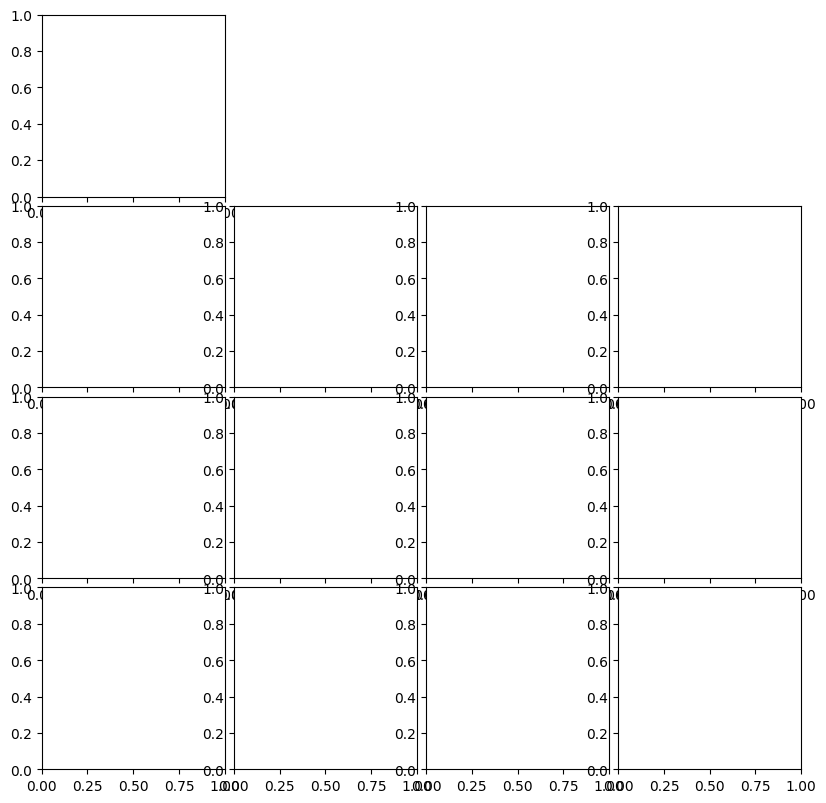

In [206]:
pears.pears(states.position);

In [124]:
tnew = np.linspace(t.min(), t.max(), 500)
vnew = jax.vmap(forward, in_axes=({k: 0 for k in samples.keys()}, None))(
    dict(samples), dict(t=tnew)
)

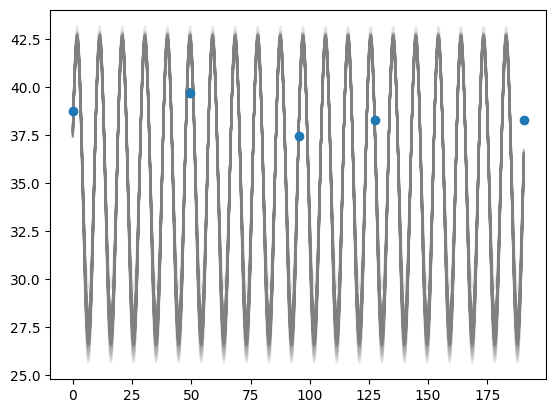

In [125]:
plt.errorbar(t, rv, yerr=err, ls="none", marker="o")
for i in range(100):
    plt.plot(tnew, vnew[i], alpha=0.2, c="gray")